In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
from fpl import (
    Loader,
    Player,
    find_matching_players,
    compute_points_per_game,
    compute_form,
)

## Expected Points Model

We make a very crude and simple model for expected points. Using the framework of [General Model Theory](https://en.wikipedia.org/wiki/Model):

##### Mapping - what phenomena are we trying to model?
Given that a player plays a particular fixture (greater than zero minutes played), we want to model how many points the player will score.

##### Reduction - what simplifying assumptions will we make?
The simplifying assumptions we will make are as follows:
- Points scored depends on only form, points per game and fixture difficulty (again, only games where a player plays more than zero minutes).
- We will make all the assumptions for a linear model (linearity, independence of errors, homoskedasticity, normality).
- There will be no attempt to estimate minutes of each player or likelihood of playing; the effect of minutes will come indirectly through points per game.
- There will be no attempt to use other useful statistics from other data sources such as betting odds, opta data, xG etc.
- We will restrict our data for analysis to gameweeks 20-24 so that averages are not calculated over so few gameweeks.

##### Pragmatism - how can we use the model from a practical point of view?
We can use this model if, for each fixture each player plays, we can calculate:
1. Their points per game so far that season, prior to the fixture.
2. Their form, prior to the fixture.
3. An indication of the difficulty of a particular fixture.

This should be relatively simple, therefore we can create a `SimpleExpectedPointsCalculator` as shown in [expected_points_calculator.py](https://github.com/aav31/fpl-toolkit/blob/main/fpl/expected_points_calculator.py) which can be plugged into our `Optimizer`.

In [2]:
# setting up the data
records = []
for player_id in range(1, len(Loader.get_static_info()["elements"])):
    player_info = Loader.get_player_basic_info(player_id)
    for gameweek in [20, 21, 22, 23, 24]:
        points_per_game = compute_points_per_game(player_id, gameweek)
        form = compute_form(player_id, gameweek)
        gameweek_info = Loader.get_player_historical_info_for_gameweek(
            player_id, gameweek
        )
        # A player can play multiple fixtures in a single gameweek i.e. a "double" gameweek
        for fixture_info in gameweek_info:
            team_id = player_info["team"]
            team_info = Loader.get_team_basic_info(team_id)
            opponent_team_id = fixture_info["opponent_team"]
            opponent_team_info = Loader.get_team_basic_info(opponent_team_id)
            fixture_difficulty = (
                opponent_team_info["strength_overall_away"]
                if fixture_info["was_home"]
                else opponent_team_info["strength_overall_home"]
            )
            if fixture_info["minutes"] == 0:
                continue
            else:
                records.append(
                    {
                        "player_id": player_id,
                        "gameweek": gameweek,
                        "fixture": fixture_info["fixture"],
                        "web_name": player_info["web_name"],
                        "team": team_info["short_name"],
                        "opponent_team": opponent_team_info["short_name"],
                        "total_points": fixture_info["total_points"],  # response
                        "form": form,  # predictor
                        "points_per_game": points_per_game,  # predictor
                        "fixture_difficulty": fixture_difficulty,  # predictor
                    }
                )

df = pd.DataFrame(records)

In [3]:
df[df["player_id"] == 328]

,player_id,gameweek,fixture,web_name,team,opponent_team,total_points,form,points_per_game,fixture_difficulty
760,328,20,196,M.Salah,LIV,MUN,7,12.8,11.2,1140
761,328,21,206,M.Salah,LIV,NFO,2,13.2,11.0,1195
762,328,22,212,M.Salah,LIV,BRE,3,11.0,10.6,1100
763,328,23,226,M.Salah,LIV,IPS,8,7.4,10.2,1075
764,328,24,232,M.Salah,LIV,BOU,16,5.0,10.1,1195
765,328,24,144,M.Salah,LIV,EVE,13,5.0,10.1,1095


#### In-sample

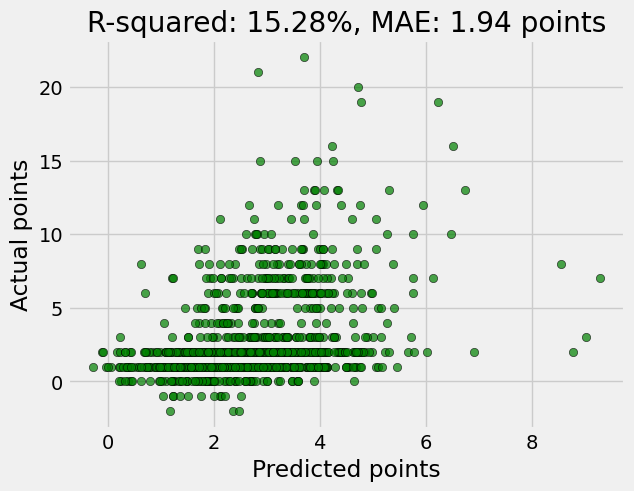

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_points   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     71.24
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           2.32e-42
Time:                        08:48:18   Log-Likelihood:                -2894.7
No. Observations:                1189   AIC:                             5797.
Df Residuals:                    1185   BIC:                             5818.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.9007      1.231      8.044      0.000       7.486      12.315
form                   0.1153      0.065      1.762      0.078      -0.013       0.244
points_per_game        0.6032      0.092      6.557      0.000       0.423       0.784
fixture_difficulty    -0.0078      0.001     -7.442      0.000      -0.010      -0.006
==============================================================================
Omnibus:                      520.357   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2715.067
Skew:                           2.002   Prob(JB):                         0.00
Kurtosis:                       9.226   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
df_train = df[df["gameweek"] < 24].copy()
model = smf.ols(
    formula="total_points ~ form + points_per_game + fixture_difficulty", data=df_train
)
fitted = model.fit()
df_train["prediction"] = fitted.predict(df_train)
df_train["residual"] = df_train["prediction"] - df_train["total_points"]
mae_in_sample = np.mean(np.abs(df_train["residual"]))
r2_in_sample = 1 - (
    np.sum(df_train["residual"] ** 2)
    / np.sum((df_train["total_points"] - np.mean(df_train["total_points"])) ** 2)
)
plt.scatter(
    df_train["prediction"],
    df_train["total_points"],
    color="green",
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("Predicted points")
plt.ylabel("Actual points")
plt.title(
    f"R-squared: {round(100*r2_in_sample, 2)}%, MAE: {round(mae_in_sample, 2)} points"
)
# plt.savefig('./resources/plot.png', dpi=300, bbox_inches='tight')
plt.show()
fitted.summary()

#### Out-of-sample

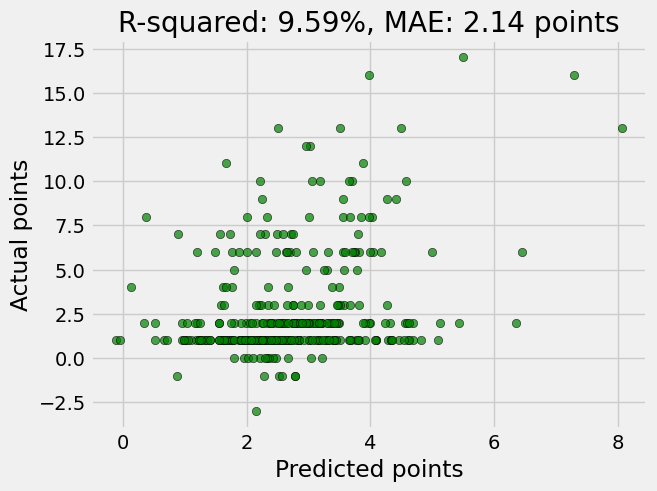

In [5]:
df_test = df[df["gameweek"] == 24].copy()
df_test["prediction"] = fitted.predict(df_test)
df_test["residual"] = df_test["prediction"] - df_test["total_points"]
mae_out_of_sample = np.mean(np.abs(df_test["residual"]))
r2_out_of_sample = 1 - (
    np.sum(df_test["residual"] ** 2)
    / np.sum((df_test["total_points"] - np.mean(df_test["total_points"])) ** 2)
)
plt.scatter(
    df_test["prediction"],
    df_test["total_points"],
    color="green",
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("Predicted points")
plt.ylabel("Actual points")
plt.title(
    f"R-squared: {round(100*r2_out_of_sample, 2)}%, MAE: {round(mae_out_of_sample, 2)} points"
)
plt.show()

## Discussion and improvements

Conditional on the dataset and our intention, the linear model is adequate. There are roughly $1000$ samples with a relatively low signal-noise ratio, therefore a high-bias and low-variance model is appropriate. Perhaps the most important thing is that the model is perfect for demonstration purposes; it is simple, explainable and can be coded up easily as shown in [expected_points_calculator.py](https://github.com/aav31/fpl-toolkit/blob/main/fpl/expected_points_calculator.py). Whilst the out-of-sample R-squared of $10\%$ is nothing to scream about, at least it gives us a systematic way of predicting the points a player will score.


### Dataset

The model would almost certainly be improved by enriching the dataset - this is the 'lowest hanging fruit':
- We could increase the number of samples $n$ by simply using a longer history of gameweeks and potentially previous seasons (though this would require extra assumptions since points rules are season dependent).
- We could increase the number of predictors $p$ by using variables from the FPL website such as `minutes`, `xG`, and `position`.
- We could increase the number of predictors $p$ by using variables from external data sources such as betting odds and opta data.

Using a larger sample size and more features would justify higher variance and lower bias models. If we were to continue using a linear model, it would be wise to address the issues discussed below.

### Linear regression

In terms of our linear regression assumptions:
- **Linearity**: From the residual plot below, the linearity assumption roughly holds.
- **Independence of errors**: Within a single gameweek, errors are not completely independent, but their dependence is somewhat limited; if a defender in a team outperforms his expected points, it's very likely a different defender in the same team outperforms his expected points, and a striker in the opposing team underperforms his expected points. In order to address this, we could model the interaction of players through a correlation matrix with some kind of factor model - though it is out of the scope of this project. In terms of correlation between errors over time, it is difficult to tell, as we only have four weeks of data. If we had more data, we would probably see something in the ACF or PACF plot for an individual player, given commentators anecdotally mention form influences performance. However, since we already use `form` as a predictor variable, maybe a time-series model is a bit overkill, though it could be useful if you were maintaining a buffer of points history.
- **Homoskedasticity**: From the residual plot below, this assumption is somewhat violated; it would be beneficial to transform the response variable, use polynomial features or use quantile regression.
- **Normality**: From the residual histogram below, this assumption is violated; it would be beneficial to transform the response variable, use polynomial features or use quantile regression. There are lots of 'points hauls' that we are not capturing; there is probably another useful predictor that would help explain the response better.

Other considerations:
- **Collinearity**: From the covariate scatter below, even with only three predictors, we already have strong correlation between two of them. This is bad for a number of reasons. Firstly, the variance of our coefficients is high - maybe when this regression is run over a different set of gameweeks, the coefficients will be a lot different. Secondly, the magnitude and sign of our coefficients may be large and opposite of what we expect - luckily this is not the case in our regression. Finally our T-tests may show some variables are insignificant when they should be - again, fortunately this is not the case, as our T-tests show all covariates are significant. If we were to use more covariates such as `shots_on_target`, `xG`, `goals` etc, it would be wise to address the collinearity issues for example by using PCA, shrinkage or subset selection.
- **Outliers**: From the influence plot below, our largest outlier is Phil Foden's performance against Ipswich in gameweek $22$ where he hauled a mammoth $19$ points. The observation is an extreme outlier in the output space (large studentized residual $t_i > 5$) but not such an extreme outlier in the input space (moderately large leverage $3(p+1)/n < h_i < 6(p+1)/n$ ). The point does not significantly distort the model by moving the regression line (Cook's distance $D_i < 1$) and, given it is an outcome we would have liked to have predicted, it is probably wise to keep it in the training set. Could we have done better? Given Foden's points statistics prior to this, we can forgive the model saying he should only score $5$. However, thoughout the season, Foden has underperformed his `xG`, therefore augmenting the dataset with this would likely be beneficial.

### Pipeline

Improvements:
- As it stands, this is an ad-hoc, offline calibration of an expected points model. In the future, it would be better to have a 'rolling' regression which is run in a more automatic way.
- `statsmodels` was chosen for its ease of use and quick exploratory capabilities. `scikit-learn` would be more appropriate in the future, given the added complexity of more features, different models, saving parameters, normalization etc.

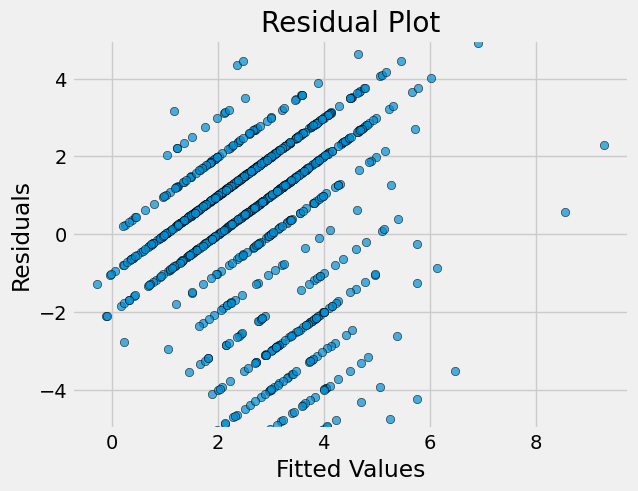

In [6]:
plt.scatter(df_train["prediction"], df_train["residual"], edgecolor="k", alpha=0.7)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-5, 5)
plt.title("Residual Plot")
plt.show()

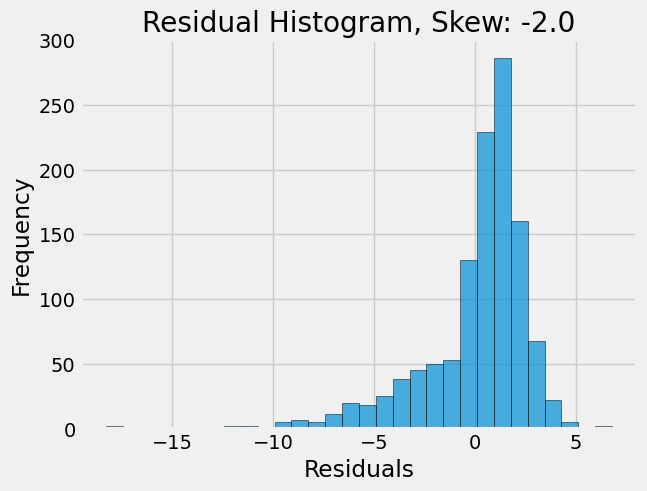

In [7]:
skew_residuals = pd.Series(df_train["residual"]).skew()
plt.hist(df_train["residual"], bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Residual Histogram, Skew: {round(skew_residuals, 2)}")
plt.show()

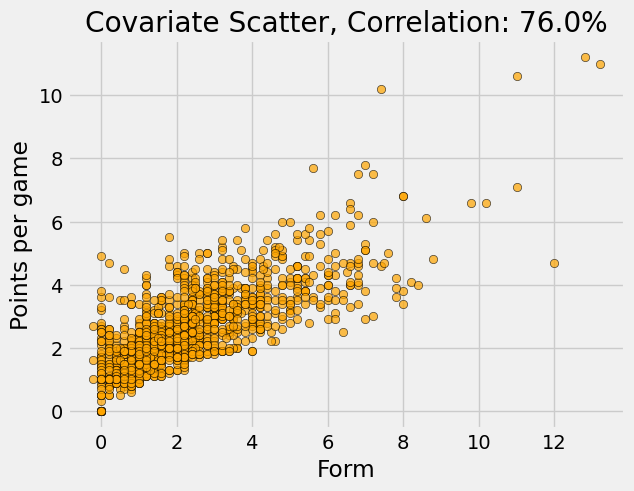

In [8]:
correlation_form_ppg = df["form"].corr(df["points_per_game"])
plt.scatter(
    df_train["form"],
    df_train["points_per_game"],
    color="orange",
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("Form")
plt.ylabel("Points per game")
plt.title(f"Covariate Scatter, Correlation: {100*round(correlation_form_ppg, 2)}%")
plt.show()

,dfb_Intercept,dfb_form,dfb_points_per_game,dfb_fixture_difficulty,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
818,0.207607,0.552756,-0.342431,-0.203274,0.092001,5.179722,0.013531,0.606634,5.237163,0.613361
761,0.082556,-0.105242,-0.209927,-0.033384,0.055745,-2.495602,0.034565,-0.472208,-2.501130,-0.473254
227,0.151813,0.072822,0.170366,-0.188204,0.045594,4.634613,0.008419,0.427056,4.675223,0.430798
954,0.073365,0.263759,-0.014442,-0.098667,0.043216,3.455082,0.014274,0.415767,3.471153,0.417701
762,-0.002124,-0.003376,-0.241114,0.046216,0.037923,-2.211702,0.030078,-0.389475,-2.215346,-0.390116


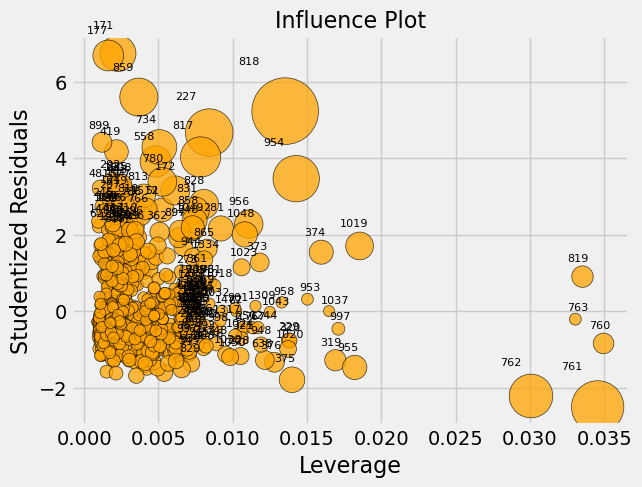

In [9]:
_, ax = plt.subplots()
sm.graphics.influence_plot(fitted, ax=ax)
# Customize the scatter plot points
points = ax.collections[0]
points.set_facecolor("orange")  # Set marker face color
points.set_edgecolor("k")  # Set marker edge color
for text in ax.texts:
    text.set_fontsize(8)  # Set the font size to 8 (or any other desired size)
df_influence = fitted.get_influence().summary_frame()
df_influence.sort_values("cooks_d", ascending=False)[:5]

In [10]:
# largest outlier
df_train.loc[818]

player_id                   348
gameweek                     22
fixture                     215
web_name                  Foden
team                        MCI
opponent_team               IPS
total_points                 19
form                        8.0
points_per_game             3.8
fixture_difficulty         1075
prediction             4.770881
residual             -14.229119
Name: 818, dtype: object